In [1]:
#t_end = 'Now'
t_end = 'Now'
duration_in_day = 330
time_interval = '2h'
a =  1.06823544
b = -5.42086628

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lsst_efd_client import EfdClient
from astropy.time import Time, TimeDelta
from matplotlib import colors as mcolors
from matplotlib.lines import Line2D

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


In [3]:
OFFSETCRYO = {
    "CIP1": -0.003171139293246799,
    "CIP2": -0.00802408324347602,
    "CIP3": -0.006236367755466037,
    "CIP4": 0.004754777307863589,
    "CIP5": -0.006450745794508193,
    "CIP6": 0.009414226920516402
}

BIN_INFLUX = time_interval
BIN_PANDAS = "1min"

# trender.py --stat --overlaystart --start '2026/1/27 00:10:00' --dur 30m   --site summit --timebins 1000  --plot 'vacuum/HX/HIP._I' 

OFFSETHEX = {
    "HIP1": 0.004332,
    "HIP2": 0.003977 
}

# Use consistent units across notebook: CryoVac [Torr], I [mA]

global_poly_coeffs = np.array([a, b])


def resolve_time_range(t_end_value, duration_days):
    t_end_str = str(t_end_value).strip()
    t_end_val = Time.now() if t_end_str.lower() == "now" else Time(t_end_str)
    t_start_val = t_end_val - TimeDelta(duration_days, format="jd")
    return t_start_val, t_end_val


def result_to_df(result):
    if isinstance(result, pd.DataFrame):
        return result
    if isinstance(result, dict):
        return list(result.values())[0] if result else pd.DataFrame()
    if isinstance(result, list):
        return result[0] if result else pd.DataFrame()
    return pd.DataFrame()


def ensure_datetime_index(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.copy()
        df.index = pd.to_datetime(df.index)
    return df


def get_query_client(efd_client):
    return (
        getattr(efd_client, "influx_client", None)
        or getattr(efd_client, "_influx_client", None)
    )


async def load_vacuum_data(
    efd_client,
    start_time,
    end_time,
    vac_topic,
    vac_field,
    cip_topic,
    cip_col,
):
    query_client = get_query_client(efd_client)
    mean_vac_col = f"mean_{vac_field}"

    if query_client is not None:
        query1 = f"""SELECT mean("{vac_field}") AS "{mean_vac_col}" FROM "lsst.MTCamera"."autogen"."{vac_topic}" 
        WHERE time > '{start_time.iso}' AND time < '{end_time.iso}' 
        GROUP BY time({BIN_INFLUX}) FILL(null)"""
        query2 = f"""SELECT mean("I") AS "mean_I", mean("V") AS "mean_V" FROM "lsst.MTCamera"."autogen"."{cip_topic}" 
        WHERE time > '{start_time.iso}' AND time < '{end_time.iso}' 
        GROUP BY time({BIN_INFLUX}), "{cip_col}" FILL(null)"""

        result1 = await query_client.query(query1)
        result2 = await query_client.query(query2)

        df1 = result_to_df(result1).rename(columns={mean_vac_col: vac_field})
        if isinstance(result2, dict):
            dfs_list = [df for df in result2.values() if isinstance(df, pd.DataFrame) and not df.empty]
            df2 = pd.concat(dfs_list) if dfs_list else pd.DataFrame()
        else:
            df2 = result_to_df(result2)
        df2 = df2.rename(columns={"mean_I": "I", "mean_V": "V"})
        return df1, df2

    print("No influx query client found; using select_time_series fallback")
    df1_raw = await efd_client.select_time_series(
        topic_name=vac_topic,
        fields=[vac_field],
        start=start_time,
        end=end_time,
    )
    df2_raw = await efd_client.select_time_series(
        topic_name=cip_topic,
        fields=["I", "V", cip_col],
        start=start_time,
        end=end_time,
    )

    df1 = ensure_datetime_index(df1_raw)[[vac_field]].resample(BIN_PANDAS).mean()
    df2 = ensure_datetime_index(df2_raw)
    if "I" not in df2.columns or "V" not in df2.columns or cip_col not in df2.columns:
        raise KeyError(f"Fallback query missing columns. Available: {list(df2.columns)}")
    df2 = (
        df2[[cip_col, "I", "V"]]
        .dropna(subset=[cip_col])
        .groupby([pd.Grouper(freq=BIN_PANDAS), cip_col])[["I", "V"]]
        .mean()
        .reset_index()
        .set_index("time")
    )
    return df1, df2


def prepare_merged_data(df1, df2, vac_col, cip_col, offsets, v_threshold=5900):
    df_merged = pd.merge(df1, df2, left_index=True, right_index=True, how="inner")
    if df_merged.empty:
        raise ValueError("No merged data found for the selected time range.")
    if "V" not in df_merged.columns:
        raise KeyError(f"V column not found after merge. Available columns: {list(df_merged.columns)}")

    df_merged = df_merged[df_merged["V"] > v_threshold].copy()
    if df_merged.empty:
        raise ValueError(f"No data points remain after applying V > {v_threshold} filter.")

    if vac_col not in df_merged.columns:
        raise KeyError(f"{vac_col} column not found after merge. Available columns: {list(df_merged.columns)}")
    if cip_col not in df_merged.columns:
        raise KeyError(f"{cip_col} column not found after merge. Available columns: {list(df_merged.columns)}")

    df_merged["I_corr"] = df_merged["I"] - df_merged[cip_col].map(offsets).fillna(0.0)
    return df_merged


def log_transform_for_base(v, base):
    return np.log10(v) if base == 10 else np.log(v)


def inv_log_transform_for_base(v, base):
    return 10 ** v if base == 10 else np.exp(v)


def plot_vacuum_vs_current(df_merged, vac_col, cip_col, title_prefix, t_start, t_end_iso):
    fig, ax = plt.subplots(figsize=(10, 6))

    unique_cips = df_merged[cip_col].dropna().unique()
    base_cmap = plt.get_cmap("tab20", len(unique_cips))
    base_colors = [base_cmap(i) for i in range(len(unique_cips))]

    time_index = pd.to_datetime(df_merged.index)
    time_num = time_index.astype("int64").to_numpy(dtype=float)
    time_norm = mcolors.Normalize(vmin=np.nanmin(time_num), vmax=np.nanmax(time_num))
    brightness = 0.3 + 0.7 * time_norm(time_num)
    brightness = np.asarray(brightness, dtype=float)

    legend_handles = []
    for i, cip in enumerate(unique_cips):
        mask = df_merged[cip_col] == cip
        base_rgb = np.array(mcolors.to_rgb(base_colors[i]))
        b = brightness[mask.to_numpy()].reshape(-1, 1)
        colors = np.clip(base_rgb * b, 0, 1).astype(float)

        ax.scatter(
            df_merged.loc[mask, vac_col],
            df_merged.loc[mask, "I_corr"],
            color=colors,
            alpha=0.9,
            s=10,
            edgecolors="none",
        )

        legend_color = np.clip(base_rgb * 0.8 + 0.2, 0, 1)
        legend_handles.append(
            Line2D(
                [0],
                [0],
                marker="o",
                linestyle="None",
                markerfacecolor=legend_color,
                markeredgecolor="none",
                markersize=8,
                label=f"{cip_col}: {cip}",
            )
        )

    log_base_for_plot = int(globals().get("LOG_BASE", 10))
    if "global_poly_coeffs" in globals() and global_poly_coeffs is not None:
        i_corr_ma_all = df_merged["I_corr"].to_numpy(dtype=float)
        valid_global = np.isfinite(i_corr_ma_all) & (i_corr_ma_all > 0)
        if np.count_nonzero(valid_global) > 2:
            i_line_ma = np.logspace(
                np.log10(np.nanmin(i_corr_ma_all[valid_global])),
                np.log10(np.nanmax(i_corr_ma_all[valid_global])),
                300,
            )
            ly = np.polyval(global_poly_coeffs, log_transform_for_base(i_line_ma, log_base_for_plot))
            x_line_torr = inv_log_transform_for_base(ly, log_base_for_plot)
            y_line_ma = i_line_ma

            deg_text = int(globals().get("global_poly_degree", len(global_poly_coeffs) - 1))
            ax.plot(x_line_torr, y_line_ma, color="red", linewidth=2.5)
            legend_handles.append(
                Line2D([0], [0], color="red", linewidth=2.5, label=f"Global poly (deg={deg_text})")
            )
    else:
        print("Cell 8 global polynomial result not found. Run Cell 8 to overlay global polynomial curve.")

    bright_greys = mcolors.LinearSegmentedColormap.from_list(
        "bright_greys", [(0.3, 0.3, 0.3), (1, 1, 1)]
    )
    sm = plt.cm.ScalarMappable(cmap=bright_greys, norm=time_norm)
    sm.set_array([])
    ticks = np.linspace(np.nanmin(time_num), np.nanmax(time_num), 6)
    cbar = fig.colorbar(sm, ax=ax, ticks=ticks)
    cbar.set_label("Time", fontsize=12)
    tick_labels = pd.to_datetime(ticks).strftime("%Y-%m-%d %H:%M")
    cbar.ax.set_yticklabels(tick_labels, rotation=30)

    x_plot = df_merged[vac_col].to_numpy(dtype=float)
    y_plot = df_merged["I_corr"].to_numpy(dtype=float)
    valid_plot = np.isfinite(x_plot) & np.isfinite(y_plot) & (x_plot > 0) & (y_plot > 0)
    if np.count_nonzero(valid_plot) > 1:
        ax.set_xlim(np.nanmin(x_plot[valid_plot]) * 0.8, np.nanmax(x_plot[valid_plot]) * 1.2)
        ax.set_ylim(np.nanmin(y_plot[valid_plot]) * 0.8, np.nanmax(y_plot[valid_plot]) * 1.2)

    ax.set_xlabel(f"{vac_col} [Torr]", fontsize=12)
    ax.set_ylabel("I [mA]", fontsize=12)
    ax.loglog()
    ax.set_title(f"{title_prefix} by {cip_col} (V > 5900) {t_start} to {t_end_iso}", fontsize=14)
    ax.legend(handles=legend_handles)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [14]:
def plot_time_series_with_prediction(
    df1,
    df2,
    vac_col,
    cip_col,
    offsets,
    title_prefix,
    t_start,
    t_end_iso,
):
    import numpy as np

    df_vac = df1.copy().rename(columns={f"mean_{vac_col}": vac_col})
    df_i = df2.copy().rename(columns={"mean_I": "I", "mean_V": "V"})

    required_df1 = {vac_col}
    required_df2 = {"I", "V", cip_col}
    if df_vac.empty or df_i.empty:
        raise ValueError(f"{vac_col} or I data is empty. Check query results.")
    if not required_df1.issubset(df_vac.columns) or not required_df2.issubset(df_i.columns):
        raise KeyError(f"Missing required columns. df1={list(df_vac.columns)}, df2={list(df_i.columns)}")

    df_i = df_i[df_i["V"] > 5900].copy()
    if df_i.empty:
        raise ValueError("No I data after applying V > 5900 filter.")

    df_vac = df_vac.sort_index()
    df_i = df_i.sort_index()
    df_i["I_corr"] = df_i["I"] - df_i[cip_col].map(offsets).fillna(0.0)

    global_only_coeffs = np.asarray(
        globals().get("global_only_coeffs", globals().get("global_poly_coeffs", np.array([1.06825829, -5.42104577]))),
        dtype=float,
    )
    log_base_pred = int(globals().get("global_poly_log_base", globals().get("LOG_BASE", 10)))

    if global_only_coeffs.size != 2:
        raise ValueError("global_only_coeffs must be a length-2 array [c1, c0] for linear log-log model.")
    if np.isclose(global_only_coeffs[0], 0.0):
        raise ValueError("global_only_coeffs[0] is zero; cannot invert model to predict I.")

    if log_base_pred == 10:
        _log = np.log10
        _invlog = lambda v: 10 ** v
    else:
        _log = np.log
        _invlog = np.exp

    vac_vals = df_vac[vac_col].to_numpy(dtype=float)
    valid_vac = np.isfinite(vac_vals) & (vac_vals > 0)
    pred_i_corr = np.full_like(vac_vals, np.nan, dtype=float)

    lx = _log(vac_vals[valid_vac])
    log_i_corr = (lx - global_only_coeffs[1]) / global_only_coeffs[0]
    pred_i_corr[valid_vac] = _invlog(log_i_corr)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    ax1.plot(df_vac.index, df_vac[vac_col], ".", color="black", linewidth=2)
    ax1.set_ylabel(f"{vac_col} [Torr]", fontsize=12)
    ax1.set_yscale("log")
    ax1.set_ylim(7e-9, 3e-7)
    ax1.grid(True, alpha=0.3)

    cips = sorted(df_i[cip_col].dropna().unique())
    cmap = plt.get_cmap("tab20", len(cips))
    for i, cip in enumerate(cips):
        sub = df_i[df_i[cip_col] == cip]
        ax2.plot(sub.index, sub["I_corr"], ".", linewidth=1.5, color=cmap(i), label=f"{cip}")

    valid_pred = np.isfinite(pred_i_corr) & (pred_i_corr > 0)
    if np.count_nonzero(valid_pred) > 1:
        ax2.plot(
            df_vac.index[valid_pred],
            pred_i_corr[valid_pred],
            "-",
            color="black",
            linewidth=2.0,
            alpha=0.9,
            label=f"Predicted I from {vac_col} (global_only_coeffs)",
        )

    ax2.set_ylabel("I [mA]", fontsize=12)
    ax2.set_xlabel("Time", fontsize=12)
    ax2.set_yscale("log")
    ax2.set_ylim(0.3e-2, 1e-1)
    ax2.grid(True, alpha=0.3)
    ax2.legend(title=cip_col, ncol=2, fontsize=9)

    plot_title = (
        f"{title_prefix} Time Series (V > 5900) {t_start} to {t_end_iso}"
        if "t_start" in globals() and "t_end_iso" in globals()
        else f"{title_prefix} Time Series (V > 5900)"
    )
    fig.suptitle(plot_title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [5]:
def ensure_i_corr_column(df, cip_col, offsets, source_col="I"):
    if "I_corr" in df.columns:
        return df
    out = df.copy()
    out["I_corr"] = out[source_col] - out[cip_col].map(offsets).fillna(0.0)
    return out


def get_fit_settings():
    return {
        "degree": int(globals().get("POLY_DEGREE", 1)),
        "log_base": int(globals().get("LOG_BASE", 10)),
        "seed_line_coeffs": np.asarray(globals().get("SEED_LINE_COEFFS", np.array([1.06825829, -5.42104577])), dtype=float),
        "seed_keep_fraction": float(globals().get("SEED_KEEP_FRACTION", 0.30)),
        "seed_num_bins": int(globals().get("SEED_NUM_BINS", 24)),
        "upper_sigma": float(globals().get("UPPER_SIGMA", 4.0)),
        "lower_sigma": float(globals().get("LOWER_SIGMA", 1.5)),
        "ref_gate_upper_sigma": float(globals().get("REFERENCE_GATE_UPPER_SIGMA", 0.6)),
        "ref_gate_lower_sigma": float(globals().get("REFERENCE_GATE_LOWER_SIGMA", 2.5)),
        "ref_gate_max_fraction": float(globals().get("REFERENCE_GATE_MAX_FRACTION", 0.30)),
        "prior_rel_scales": np.asarray(globals().get("PRIOR_REL_SCALES", [0.05, 0.03]), dtype=float),
        "penalty_strength": float(globals().get("PENALTY_STRENGTH", 120.0)),
        "original_coeffs": np.array([1.06825829, -5.42104577], dtype=float),
    }

Resolved time range: 2025-04-04 21:01:47.806 -> 2026-02-28 21:01:47.806


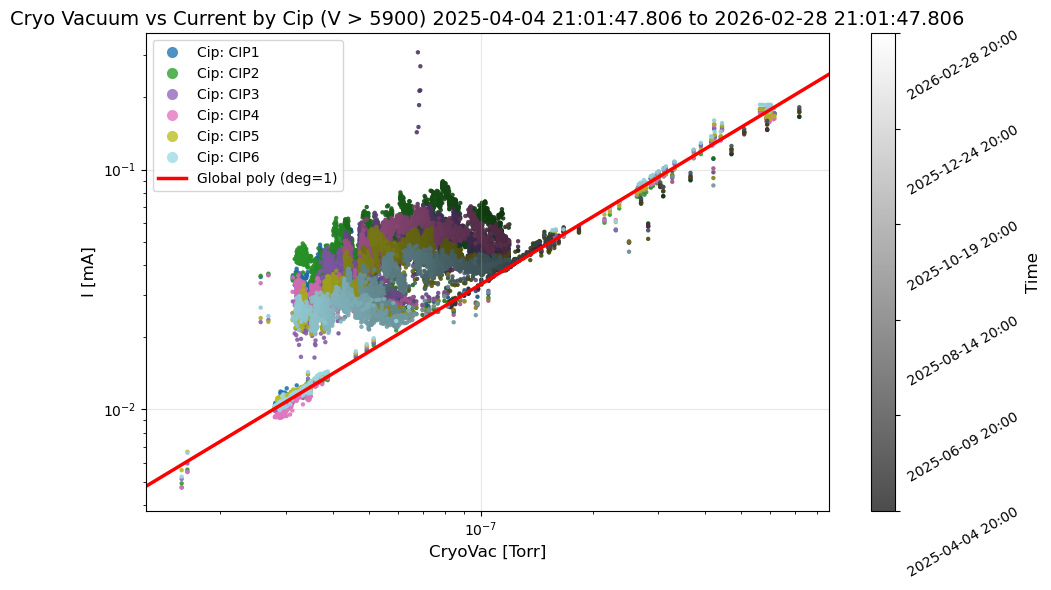

In [15]:
# Use consistent units across notebook: CryoVac [Torr], I [mA]

client = EfdClient("usdf_efd")

t_start_val, t_end_val = resolve_time_range(t_end, duration_in_day)
t_start = t_start_val.iso
t_end_iso = t_end_val.iso
print(f"Resolved time range: {t_start} -> {t_end_iso}")

df1, df2 = await load_vacuum_data(
    client,
    t_start_val,
    t_end_val,
    vac_topic="lsst.MTCamera.vacuum_cryo",
    vac_field="CryoVac",
    cip_topic="lsst.MTCamera.vacuum_cryo_cip",
    cip_col="Cip",
)

df_merged = prepare_merged_data(
    df1=df1,
    df2=df2,
    vac_col="CryoVac",
    cip_col="Cip",
    offsets=OFFSETCRYO,
    v_threshold=5900,
)

plot_vacuum_vs_current(
    df_merged=df_merged,
    vac_col="CryoVac",
    cip_col="Cip",
    title_prefix="Cryo Vacuum vs Current",
    t_start=t_start,
    t_end_iso=t_end_iso,
)

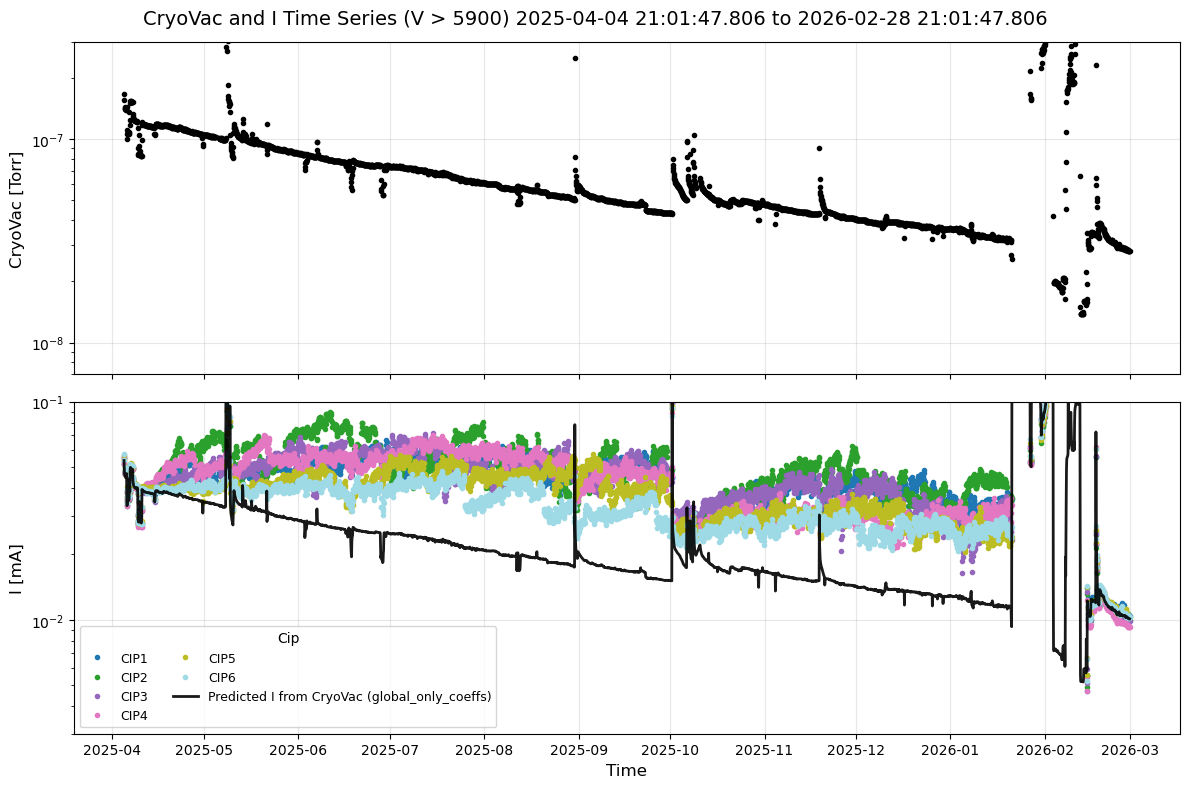

In [16]:
# Time-series plot: CryoVac and I for each CIP
if "df1" not in globals() or "df2" not in globals():
    raise RuntimeError("Run the Cryo data-load cell first to load df1/df2.")

plot_time_series_with_prediction(
    df1=df1,
    df2=df2,
    vac_col="CryoVac",
    cip_col="Cip",
    offsets=OFFSETCRYO,
    title_prefix="CryoVac and I",
    t_start=t_start,
    t_end_iso=t_end_iso,
)

In [17]:
POLY_DEGREE = 1

# Main-line favoring asymmetric clipping
UPPER_SIGMA = 4.0
LOWER_SIGMA = 1.1
SEED_KEEP_FRACTION = 0.25

# Reference-line gate (asymmetric):
# reject points far ABOVE reference more strongly to avoid cloud-drag.
REFERENCE_GATE_UPPER_SIGMA = 0.6
REFERENCE_GATE_LOWER_SIGMA = 2.5
REFERENCE_GATE_MAX_FRACTION = 0.30

,CIP,degree,log_base,n_total,n_positive,n_inliers,seed_keep_fraction,seed_num_bins,upper_sigma,lower_sigma,ref_gate_upper_sigma,ref_gate_lower_sigma,ref_gate_max_fraction,prior_rel_scales,penalty_strength,status,c1,c0
0,CIP1,1,10,3670,3670,877,0.25,24,4.0,1.1,0.6,2.5,0.3,"[0.05, 0.03]",120.0,ok,1.070085,-5.433312
1,CIP2,1,10,3670,3670,1101,0.25,24,4.0,1.1,0.6,2.5,0.3,"[0.05, 0.03]",120.0,ok,1.072036,-5.448037
2,CIP3,1,10,3670,3670,301,0.25,24,4.0,1.1,0.6,2.5,0.3,"[0.05, 0.03]",120.0,ok,1.068252,-5.421018
3,CIP4,1,10,3670,3670,1101,0.25,24,4.0,1.1,0.6,2.5,0.3,"[0.05, 0.03]",120.0,ok,1.071560,-5.443049
4,CIP5,1,10,3670,3670,294,0.25,24,4.0,1.1,0.6,2.5,0.3,"[0.05, 0.03]",120.0,ok,1.068361,-5.421627
5,CIP6,1,10,3670,3670,297,0.25,24,4.0,1.1,0.6,2.5,0.3,"[0.05, 0.03]",120.0,ok,1.068316,-5.421379


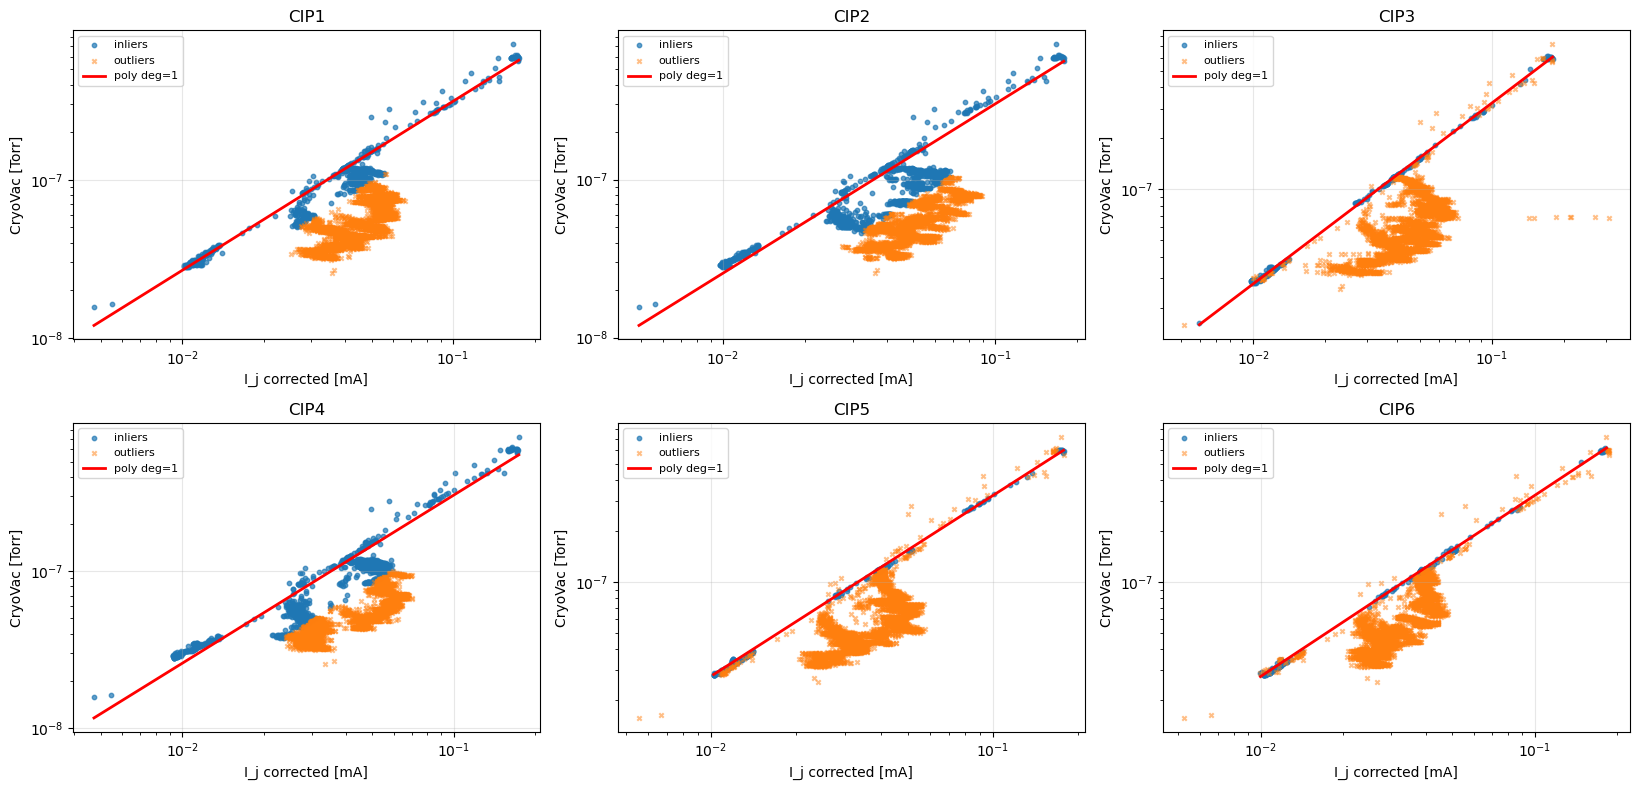

In [18]:
# Robust log-log polynomial fit for each CIP (penalized optimization against reference coeffs)
if "df_merged" not in globals():
    raise RuntimeError("Run a data-load cell first to build df_merged.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fit_settings = get_fit_settings()
POLY_DEGREE = fit_settings["degree"]
LOG_BASE = fit_settings["log_base"]
SEED_LINE_COEFFS = fit_settings["seed_line_coeffs"]
SEED_KEEP_FRACTION = fit_settings["seed_keep_fraction"]
SEED_NUM_BINS = fit_settings["seed_num_bins"]
UPPER_SIGMA = fit_settings["upper_sigma"]
LOWER_SIGMA = fit_settings["lower_sigma"]
REFERENCE_GATE_UPPER_SIGMA = fit_settings["ref_gate_upper_sigma"]
REFERENCE_GATE_LOWER_SIGMA = fit_settings["ref_gate_lower_sigma"]
REFERENCE_GATE_MAX_FRACTION = fit_settings["ref_gate_max_fraction"]
PRIOR_REL_SCALES = fit_settings["prior_rel_scales"]
PENALTY_STRENGTH = fit_settings["penalty_strength"]
ORIGINAL_COEFFS = fit_settings["original_coeffs"]

def log_transform(v, base):
    if base == 10:
        return np.log10(v)
    return np.log(v)

def inv_log_transform(v, base):
    if base == 10:
        return 10 ** v
    return np.exp(v)

def fit_linear_with_prior(lx, ly, ref_coeffs, rel_scale=(0.05, 0.05), prior_strength=120.0):
    A = np.column_stack([lx, np.ones_like(lx)])
    y = ly
    ref = np.asarray(ref_coeffs, dtype=float)
    rel_scale = np.asarray(rel_scale, dtype=float)
    if rel_scale.size == 1:
        rel_scale = np.repeat(rel_scale.item(), ref.size)
    elif rel_scale.size != ref.size:
        rel_scale = np.resize(rel_scale, ref.size)
    prior_strength = float(max(0.0, prior_strength))

    scale = np.maximum(np.abs(ref) * rel_scale, rel_scale)
    W = np.diag(1.0 / scale)

    if prior_strength == 0.0:
        coeffs, *_ = np.linalg.lstsq(A, y, rcond=None)
        return coeffs

    sqrt_lam = np.sqrt(prior_strength)
    A_aug = np.vstack([A, sqrt_lam * W])
    y_aug = np.concatenate([y, sqrt_lam * (W @ ref)])
    coeffs, *_ = np.linalg.lstsq(A_aug, y_aug, rcond=None)
    return coeffs

def build_seed_mask_from_reference(lx, ly, a0, b0, keep_fraction=0.30, num_bins=24, min_points=12):
    resid = np.abs(ly - (a0 * lx + b0))
    keep_fraction = float(np.clip(keep_fraction, 0.05, 1.0))
    num_bins = int(max(6, num_bins))

    k_global = max(min_points, int(np.ceil(keep_fraction * lx.size)))
    idx_global = np.argsort(resid)[:k_global]

    bins = np.linspace(np.nanmin(lx), np.nanmax(lx), num_bins + 1)
    selected = set(idx_global.tolist())
    for bi in range(num_bins):
        in_bin = np.where((lx >= bins[bi]) & (lx < bins[bi + 1]))[0]
        if in_bin.size == 0:
            continue
        k_bin = max(1, int(np.ceil(keep_fraction * in_bin.size)))
        local = in_bin[np.argsort(resid[in_bin])[:k_bin]]
        selected.update(local.tolist())

    seed_mask = np.zeros_like(lx, dtype=bool)
    if selected:
        seed_mask[np.fromiter(selected, dtype=int)] = True
    if np.count_nonzero(seed_mask) < min_points:
        seed_mask[np.argsort(resid)[:min_points]] = True
    return seed_mask

def build_reference_gate_mask(
    lx,
    ly,
    ref_coeffs,
    gate_upper_sigma=0.6,
    gate_lower_sigma=2.5,
    max_fraction=0.30,
    min_points=12,
):
    if ref_coeffs is None or np.size(ref_coeffs) != 2:
        return np.ones_like(lx, dtype=bool)

    a0, b0 = np.asarray(ref_coeffs, dtype=float)
    resid_ref = ly - (a0 * lx + b0)

    abs_resid = np.abs(resid_ref)
    med_abs = np.median(abs_resid)
    sigma_ref = 1.4826 * med_abs if np.isfinite(med_abs) and med_abs > 0 else np.nan

    if not np.isfinite(sigma_ref) or sigma_ref <= 0:
        k = max(min_points, int(np.ceil(max_fraction * lx.size)))
        keep_idx = np.argsort(abs_resid)[:k]
        mask = np.zeros_like(lx, dtype=bool)
        mask[keep_idx] = True
        return mask

    lo = -gate_lower_sigma * sigma_ref
    hi = gate_upper_sigma * sigma_ref
    band = (resid_ref >= lo) & (resid_ref <= hi)

    k = max(min_points, int(np.ceil(max_fraction * lx.size)))
    keep_idx = np.argsort(abs_resid)[:k]
    topk = np.zeros_like(lx, dtype=bool)
    topk[keep_idx] = True

    gate_mask = band & topk
    if np.count_nonzero(gate_mask) < min_points:
        gate_mask = topk
    return gate_mask

def robust_poly_loglog_fit(
    x, y, degree=1, max_iter=10, min_points=None, log_base=10,
    seed_line_coeffs=None, seed_keep_fraction=0.30, seed_num_bins=24,
    upper_sigma=2.0, lower_sigma=4.0,
    ref_coeffs=None, rel_scale=(0.05, 0.05), prior_strength=120.0,
    ref_gate_upper_sigma=0.6, ref_gate_lower_sigma=2.5, ref_gate_max_fraction=0.30,
):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    if min_points is None:
        min_points = max(16, degree + 6)

    valid = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    x_valid = x[valid]
    y_valid = y[valid]
    if x_valid.size < min_points:
        return None, np.zeros_like(valid, dtype=bool), "insufficient positive points"

    lx = log_transform(x_valid, log_base)
    ly = log_transform(y_valid, log_base)

    if seed_line_coeffs is not None and np.size(seed_line_coeffs) == 2:
        a0, b0 = np.asarray(seed_line_coeffs, dtype=float)
        inlier_local = build_seed_mask_from_reference(
            lx, ly, a0, b0,
            keep_fraction=seed_keep_fraction,
            num_bins=seed_num_bins,
            min_points=min_points,
        )
    else:
        inlier_local = np.ones_like(lx, dtype=bool)

    gate_mask = build_reference_gate_mask(
        lx,
        ly,
        ref_coeffs=ref_coeffs,
        gate_upper_sigma=ref_gate_upper_sigma,
        gate_lower_sigma=ref_gate_lower_sigma,
        max_fraction=ref_gate_max_fraction,
        min_points=min_points,
    )
    inlier_local = inlier_local & gate_mask
    if np.count_nonzero(inlier_local) < min_points:
        inlier_local = gate_mask.copy()

    for _ in range(max_iter):
        if np.count_nonzero(inlier_local) < min_points:
            return None, np.zeros_like(valid, dtype=bool), "insufficient inliers"

        if degree == 1 and ref_coeffs is not None:
            coeffs = fit_linear_with_prior(
                lx[inlier_local], ly[inlier_local],
                ref_coeffs=ref_coeffs,
                rel_scale=rel_scale,
                prior_strength=prior_strength,
            )
        else:
            coeffs = np.polyfit(lx[inlier_local], ly[inlier_local], degree)

        resid = ly - np.polyval(coeffs, lx)
        med = np.median(resid[inlier_local])
        mad = np.median(np.abs(resid[inlier_local] - med))
        if mad == 0 or not np.isfinite(mad):
            break

        robust_sigma = 1.4826 * mad
        lo = med - lower_sigma * robust_sigma
        hi = med + upper_sigma * robust_sigma
        new_inlier_local = (resid >= lo) & (resid <= hi) & gate_mask

        if np.count_nonzero(new_inlier_local) < min_points:
            idx = np.argsort(np.abs(resid - med))[:min_points]
            new_inlier_local = np.zeros_like(inlier_local, dtype=bool)
            new_inlier_local[idx] = True
            new_inlier_local &= gate_mask
            if np.count_nonzero(new_inlier_local) < min_points:
                idx = np.where(gate_mask)[0][:min_points]
                new_inlier_local = np.zeros_like(inlier_local, dtype=bool)
                new_inlier_local[idx] = True

        if np.array_equal(new_inlier_local, inlier_local):
            inlier_local = new_inlier_local
            break
        inlier_local = new_inlier_local

    if np.count_nonzero(inlier_local) < min_points:
        return None, np.zeros_like(valid, dtype=bool), "insufficient inliers after clipping"

    if degree == 1 and ref_coeffs is not None:
        coeffs = fit_linear_with_prior(
            lx[inlier_local], ly[inlier_local],
            ref_coeffs=ref_coeffs,
            rel_scale=rel_scale,
            prior_strength=prior_strength,
        )
    else:
        coeffs = np.polyfit(lx[inlier_local], ly[inlier_local], degree)

    inlier_full = np.zeros_like(valid, dtype=bool)
    inlier_full[np.where(valid)[0][inlier_local]] = True
    return coeffs, inlier_full, "ok"

df_merged = ensure_i_corr_column(df_merged, cip_col="Cip", offsets=OFFSETCRYO)

x_col = "I_corr"
y_col = "CryoVac"
cips = sorted(df_merged["Cip"].dropna().unique())
coef_labels = [f"c{k}" for k in range(POLY_DEGREE, -1, -1)]

fit_rows = []
fit_cache = {}
poly_coeffs_by_cip = {}

for cip in cips:
    sub = df_merged[df_merged["Cip"] == cip].copy()

    coeffs, inlier_mask, status = robust_poly_loglog_fit(
        sub[x_col].to_numpy(),
        sub[y_col].to_numpy(),
        degree=POLY_DEGREE,
        log_base=LOG_BASE,
        seed_line_coeffs=SEED_LINE_COEFFS,
        seed_keep_fraction=SEED_KEEP_FRACTION,
        seed_num_bins=SEED_NUM_BINS,
        upper_sigma=UPPER_SIGMA,
        lower_sigma=LOWER_SIGMA,
        ref_coeffs=ORIGINAL_COEFFS,
        rel_scale=PRIOR_REL_SCALES,
        prior_strength=PENALTY_STRENGTH,
        ref_gate_upper_sigma=REFERENCE_GATE_UPPER_SIGMA,
        ref_gate_lower_sigma=REFERENCE_GATE_LOWER_SIGMA,
        ref_gate_max_fraction=REFERENCE_GATE_MAX_FRACTION,
    )

    n_total = len(sub)
    valid_pos = np.isfinite(sub[x_col].to_numpy()) & np.isfinite(sub[y_col].to_numpy()) & (sub[x_col].to_numpy() > 0) & (sub[y_col].to_numpy() > 0)
    n_positive = int(np.count_nonzero(valid_pos))
    n_inliers = int(np.count_nonzero(inlier_mask))

    row = {
        "CIP": cip,
        "degree": POLY_DEGREE,
        "log_base": LOG_BASE,
        "n_total": n_total,
        "n_positive": n_positive,
        "n_inliers": n_inliers,
        "seed_keep_fraction": SEED_KEEP_FRACTION,
        "seed_num_bins": SEED_NUM_BINS,
        "upper_sigma": UPPER_SIGMA,
        "lower_sigma": LOWER_SIGMA,
        "ref_gate_upper_sigma": REFERENCE_GATE_UPPER_SIGMA,
        "ref_gate_lower_sigma": REFERENCE_GATE_LOWER_SIGMA,
        "ref_gate_max_fraction": REFERENCE_GATE_MAX_FRACTION,
        "prior_rel_scales": PRIOR_REL_SCALES.tolist(),
        "penalty_strength": PENALTY_STRENGTH,
        "status": status,
    }
    for idx, label in enumerate(coef_labels):
        row[label] = np.nan if coeffs is None else coeffs[idx]
    fit_rows.append(row)

    poly_coeffs_by_cip[cip] = coeffs
    fit_cache[cip] = {
        "x": sub[x_col].to_numpy(dtype=float),
        "y": sub[y_col].to_numpy(dtype=float),
        "inlier": inlier_mask,
        "coeffs": coeffs,
    }

fit_poly_df = pd.DataFrame(fit_rows).sort_values("CIP")
display(fit_poly_df)

n = len(cips)
ncols = 3
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5.5 * ncols, 4.0 * nrows))
axes = np.atleast_1d(axes).ravel()

for i, cip in enumerate(cips):
    ax = axes[i]
    d = fit_cache[cip]
    x = d["x"]
    y = d["y"]
    m = d["inlier"]
    coeffs = d["coeffs"]

    valid_pos = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    inl = valid_pos & m
    outl = valid_pos & (~m)

    ax.scatter(x[inl], y[inl], s=10, alpha=0.7, label="inliers")
    ax.scatter(x[outl], y[outl], s=10, alpha=0.5, marker="x", label="outliers")

    if coeffs is not None and np.count_nonzero(inl) > 2:
        xs = np.logspace(np.log10(np.nanmin(x[inl])), np.log10(np.nanmax(x[inl])), 200)
        ly = np.polyval(coeffs, log_transform(xs, LOG_BASE))
        ys = inv_log_transform(ly, LOG_BASE)
        ax.plot(xs, ys, "r-", linewidth=2, label=f"poly deg={POLY_DEGREE}")

    ax.set_title(f"{cip}")
    ax.set_xlabel("I_j corrected [mA]")
    ax.set_ylabel("CryoVac [Torr]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

,fit_scope,degree,log_base,n_total,n_positive,n_inliers,seed_keep_fraction,seed_num_bins,upper_sigma,lower_sigma,ref_gate_upper_sigma,ref_gate_lower_sigma,ref_gate_max_fraction,prior_rel_scales,penalty_strength,status,c1,c0,rel_dev_c1,rel_dev_c0
0,ALL_CIP,1,10,22020,22020,1798,0.25,24,4.0,1.1,0.6,2.5,0.3,"[0.05, 0.03]",120.0,ok,1.068142,-5.420391,-0.000109,-0.000121


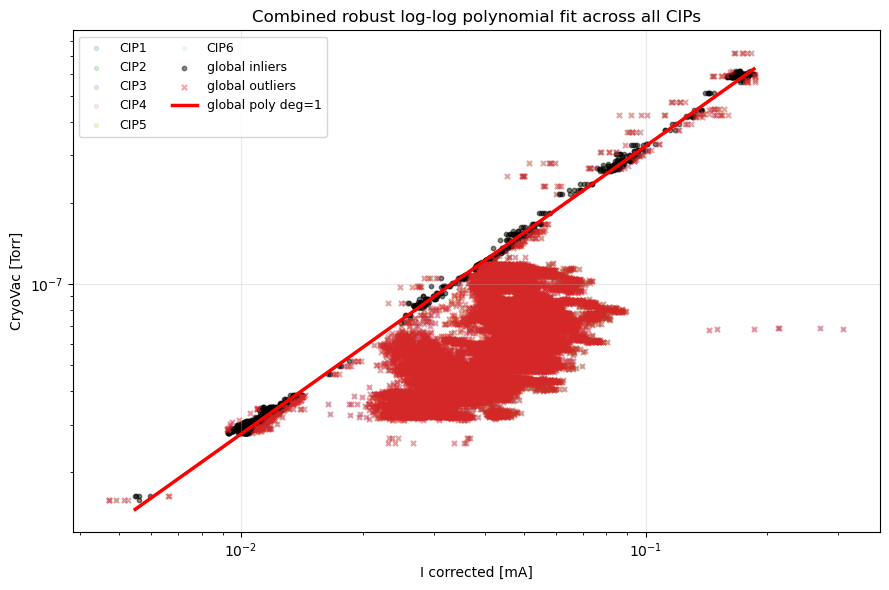

In [19]:
# Combined robust log-log polynomial fit across all CIPs
if "df_merged" not in globals():
    raise RuntimeError("Run a data-load cell first to build df_merged.")
if "robust_poly_loglog_fit" not in globals():
    raise RuntimeError("Run the per-CIP fit cell first to define robust_poly_loglog_fit.")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fit_settings = get_fit_settings()
degree = fit_settings["degree"]
log_base = fit_settings["log_base"]
seed_line_coeffs = fit_settings["seed_line_coeffs"]
seed_keep_fraction = fit_settings["seed_keep_fraction"]
seed_num_bins = fit_settings["seed_num_bins"]
upper_sigma = fit_settings["upper_sigma"]
lower_sigma = fit_settings["lower_sigma"]
ref_gate_upper_sigma = fit_settings["ref_gate_upper_sigma"]
ref_gate_lower_sigma = fit_settings["ref_gate_lower_sigma"]
ref_gate_max_fraction = fit_settings["ref_gate_max_fraction"]
prior_rel_scales = fit_settings["prior_rel_scales"]
penalty_strength = fit_settings["penalty_strength"]
original_coeffs = fit_settings["original_coeffs"]

df_all = ensure_i_corr_column(df_merged, cip_col="Cip", offsets=OFFSETCRYO).copy()

coeffs_all, inlier_mask_all, status_all = robust_poly_loglog_fit(
    df_all["I_corr"].to_numpy(),
    df_all["CryoVac"].to_numpy(),
    degree=degree,
    log_base=log_base,
    seed_line_coeffs=seed_line_coeffs,
    seed_keep_fraction=seed_keep_fraction,
    seed_num_bins=seed_num_bins,
    upper_sigma=upper_sigma,
    lower_sigma=lower_sigma,
    ref_coeffs=original_coeffs,
    rel_scale=prior_rel_scales,
    prior_strength=penalty_strength,
    ref_gate_upper_sigma=ref_gate_upper_sigma,
    ref_gate_lower_sigma=ref_gate_lower_sigma,
    ref_gate_max_fraction=ref_gate_max_fraction,
)

x_all = df_all["I_corr"].to_numpy(dtype=float)
y_all = df_all["CryoVac"].to_numpy(dtype=float)
valid_pos_all = np.isfinite(x_all) & np.isfinite(y_all) & (x_all > 0) & (y_all > 0)
inl_all = valid_pos_all & inlier_mask_all
outl_all = valid_pos_all & (~inlier_mask_all)

coef_labels = [f"c{k}" for k in range(degree, -1, -1)]
summary_row = {
    "fit_scope": "ALL_CIP",
    "degree": degree,
    "log_base": log_base,
    "n_total": int(len(df_all)),
    "n_positive": int(np.count_nonzero(valid_pos_all)),
    "n_inliers": int(np.count_nonzero(inl_all)),
    "seed_keep_fraction": seed_keep_fraction,
    "seed_num_bins": seed_num_bins,
    "upper_sigma": upper_sigma,
    "lower_sigma": lower_sigma,
    "ref_gate_upper_sigma": ref_gate_upper_sigma,
    "ref_gate_lower_sigma": ref_gate_lower_sigma,
    "ref_gate_max_fraction": ref_gate_max_fraction,
    "prior_rel_scales": prior_rel_scales.tolist(),
    "penalty_strength": penalty_strength,
    "status": status_all,
}
for idx, label in enumerate(coef_labels):
    summary_row[label] = np.nan if coeffs_all is None else coeffs_all[idx]

if coeffs_all is not None and degree == 1:
    summary_row["rel_dev_c1"] = (coeffs_all[0] - original_coeffs[0]) / original_coeffs[0]
    summary_row["rel_dev_c0"] = (coeffs_all[1] - original_coeffs[1]) / original_coeffs[1]

summary_poly_df = pd.DataFrame([summary_row])
display(summary_poly_df)

global_poly_coeffs = coeffs_all
global_poly_degree = degree
global_poly_log_base = log_base

fig, ax = plt.subplots(figsize=(9, 6))
cips_all = sorted(df_all["Cip"].dropna().unique())
cmap = plt.get_cmap("tab20", len(cips_all))
for i, cip in enumerate(cips_all):
    s = df_all[df_all["Cip"] == cip]
    xx = s["I_corr"].to_numpy(dtype=float)
    yy = s["CryoVac"].to_numpy(dtype=float)
    vv = np.isfinite(xx) & np.isfinite(yy) & (xx > 0) & (yy > 0)
    ax.scatter(xx[vv], yy[vv], s=8, alpha=0.18, color=cmap(i), label=cip)

ax.scatter(x_all[inl_all], y_all[inl_all], s=10, alpha=0.45, color="k", label="global inliers")
ax.scatter(x_all[outl_all], y_all[outl_all], s=14, alpha=0.4, marker="x", color="tab:red", label="global outliers")

if coeffs_all is not None and np.count_nonzero(inl_all) > 2:
    xs = np.logspace(np.log10(np.nanmin(x_all[inl_all])), np.log10(np.nanmax(x_all[inl_all])), 300)
    ly = np.polyval(coeffs_all, log_transform(xs, log_base))
    ys = inv_log_transform(ly, log_base)
    ax.plot(xs, ys, "r-", linewidth=2.5, label=f"global poly deg={degree}")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("I corrected [mA]")
ax.set_ylabel("CryoVac [Torr]")
ax.set_title("Combined robust log-log polynomial fit across all CIPs")
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

In [20]:

global_poly_coeffs

array([ 1.06814177, -5.42039057])

Resolved time range: 2025-04-04 21:02:15.511 -> 2026-02-28 21:02:15.511


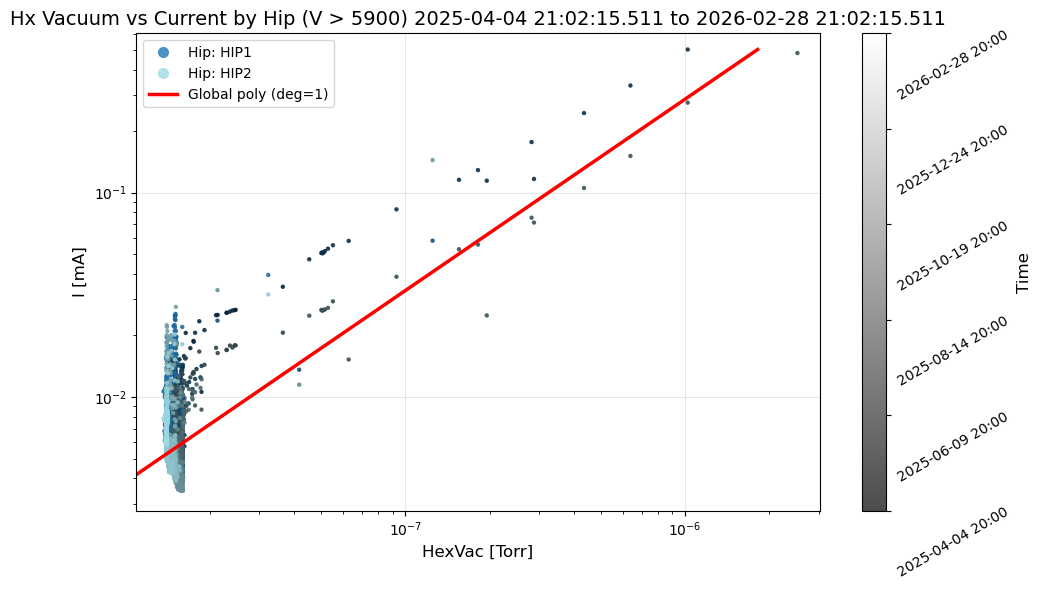

In [21]:
client = EfdClient("usdf_efd")

t_start_val, t_end_val = resolve_time_range(t_end, duration_in_day)
t_start = t_start_val.iso
t_end_iso = t_end_val.iso
print(f"Resolved time range: {t_start} -> {t_end_iso}")

df1, df2 = await load_vacuum_data(
    client,
    t_start_val,
    t_end_val,
    vac_topic="lsst.MTCamera.vacuum_hx",
    vac_field="HexVac",
    cip_topic="lsst.MTCamera.vacuum_hx_hip",
    cip_col="Hip",
)

df_merged = prepare_merged_data(
    df1=df1,
    df2=df2,
    vac_col="HexVac",
    cip_col="Hip",
    offsets=OFFSETHEX,
    v_threshold=5900,
)

plot_vacuum_vs_current(
    df_merged=df_merged,
    vac_col="HexVac",
    cip_col="Hip",
    title_prefix="Hx Vacuum vs Current",
    t_start=t_start,
    t_end_iso=t_end_iso,
)

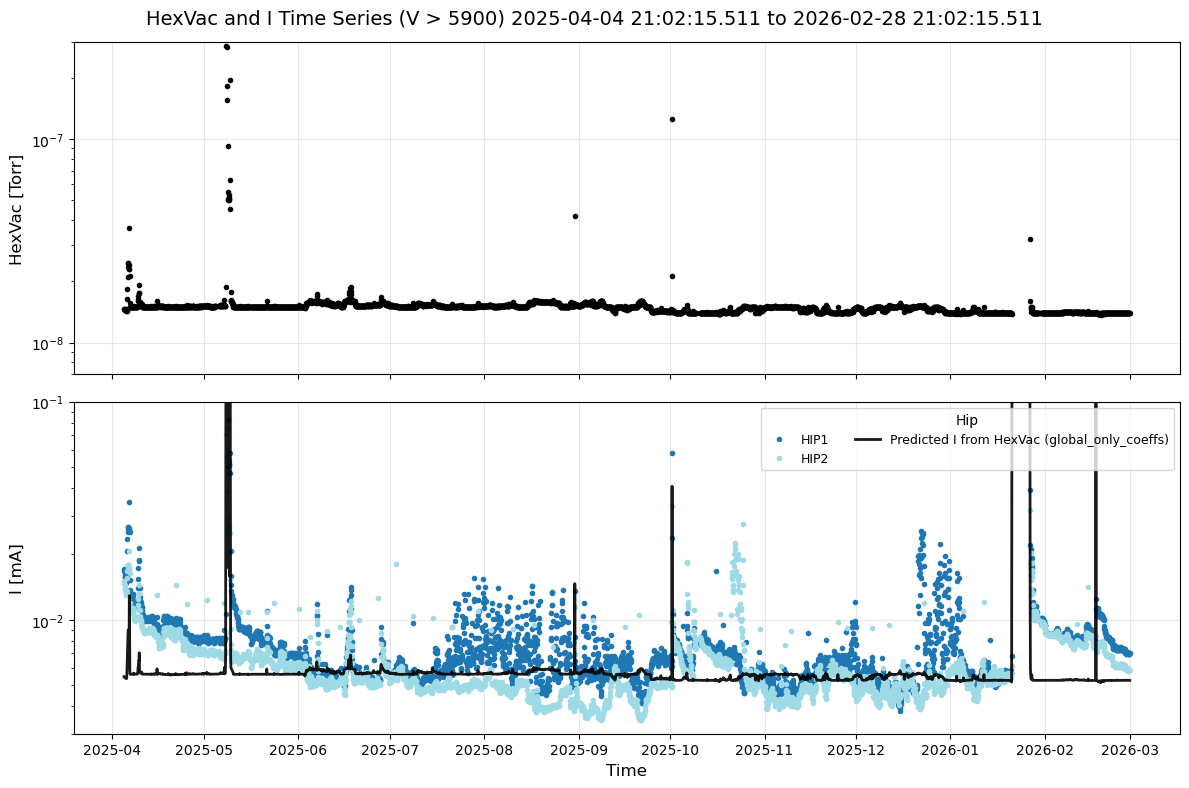

In [22]:
# Time-series plot: HexVac and I for each CIP
if "df1" not in globals() or "df2" not in globals():
    raise RuntimeError("Run the Hex data-load cell first to load df1/df2.")

plot_time_series_with_prediction(
    df1=df1,
    df2=df2,
    vac_col="HexVac",
    cip_col="Hip",
    offsets=OFFSETHEX,
    title_prefix="HexVac and I",
    t_start=t_start,
    t_end_iso=t_end_iso,
)